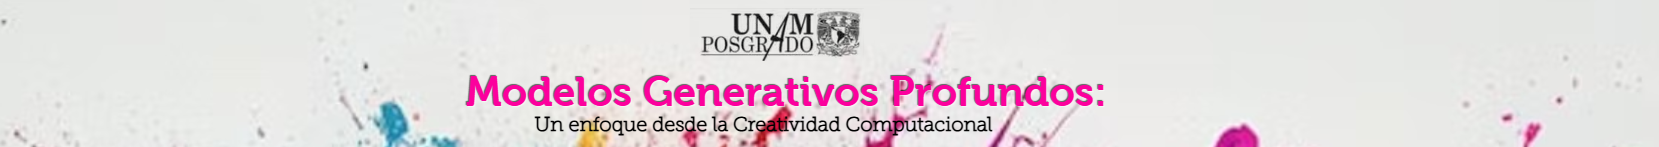

# Implementación de LeNet-5 para MNIST


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, utils, datasets, Sequential
print(tf.__version__)
tf.config.list_physical_devices('GPU')

## 1. Preparar los datos

**1.1 Descargar el dataset**

In [ ]:

(x_train, y_train), (x_test, y_test) = datasets.mnist.load_data()

In [ ]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

**1.2 Escalar los valores de las imágenes**


In [ ]:
x_train = x_train.astype("float32")/255.0
x_test = x_test.astype("float32")/255.0

**1.3 Codificar las etiquetas con one-hot-encoding.**


In [ ]:
y_train = utils.to_categorical(y_train, 10)
y_test = utils.to_categorical(y_test, 10)

Veamos las primeras 10 imágenes del conjunto de entrenamiento junto con sus etiquetas codificadas usando one-hot encoding.

In [ ]:
def display(images, n=10, size=(28, 3), cmap="gray", as_type="float32"):
    """
    Despliega hasta n imágenes de un arreglo de imágenes.
    """

    plt.figure(figsize=size)

    for i in range(min(n, len(images))):
        plt.subplot(1, n, i + 1)
        plt.imshow(images[i].astype(as_type).squeeze(), cmap=cmap)
        plt.axis("off")

    plt.show()


In [ ]:
images = x_train[:10]

plt.figure()
for i in range(0, len(images)):
  plt.subplot(1, 10, i + 1)
  plt.imshow(images[i], cmap="gray_r")
  plt.axis("off")

plt.show()

print(y_train[:10])

## 2. Construir el modelo <a name="build"></a>

Kernel de 5x5x1

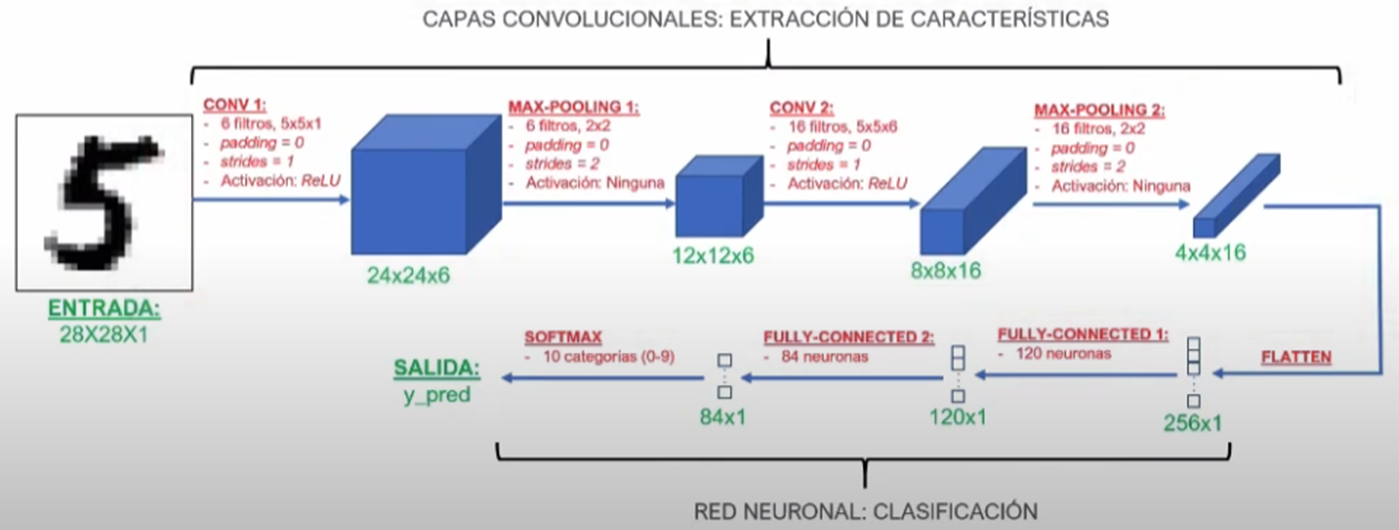

In [ ]:
NUM_CLASES = 10

data_aug = Sequential([
    layers.RandomTranslation(0.08, 0.08, fill_mode="constant", fill_value=0.0), # traslación ±4 px
    layers.RandomRotation(0.1, fill_mode="constant", fill_value=0.0),           # rotación ~±10°
    layers.RandomZoom(0.1, fill_mode="constant", fill_value=0.0),               # zoom ±10%
    layers.RandomShear(0.1, fill_mode="constant", fill_value=0.0)               # “inclina” la imagen hasta un 10%
], name="aug")

input_layer = layers.Input(shape=(28, 28,1))
x = layers.ZeroPadding2D(padding=2)(input_layer)  # dar “aire” al dígito: pad a 32×32
x = data_aug(x)
x = layers.Conv2D(filters=16, kernel_size=(5,5), padding="same", strides=(1,1), activation="relu")(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Conv2D(filters=32, kernel_size=(5,5), padding="same", strides=(1,1), activation="relu")(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Conv2D(64, kernel_size=(5, 5), padding="same", strides=(1,1), activation="relu")(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Flatten()(x)
x = layers.Dense(120, activation="relu")(x)
x = layers.Dense(84, activation="relu")(x)
output_layer = layers.Dense(NUM_CLASES, activation="softmax")(x)

model = models.Model(inputs=input_layer, outputs=output_layer)

Podemos utilizar el método <b>model.summary()</b> para inspeccionar la forma de la red en cada capa.

In [ ]:
model.summary()

## 3. Compilar el modelo <a name="compile"></a>

In [ ]:
opt = optimizers.SGD(learning_rate=0.1)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

## 4. Entrenar el modelo <a name="train"></a>

In [ ]:
model.fit(x_train, y_train, batch_size=128, epochs=20, shuffle=True)

## 5. Evaluar el modelo

In [ ]:
model.evaluate(x_test, y_test)

Podemos observar algunas de las predicciones en el conjunto de prueba utilizando el <b>método predict</b>: <br>


In [ ]:
CLASSES = np.array(
    [
        "0",
        "1",
        "2",
        "3",
        "4",
        "5",
        "6",
        "7",
        "8",
        "9",
    ]
)

preds = model.predict(x_test)
preds_single = CLASSES[np.argmax(preds, axis=-1)]
actual_single = CLASSES[np.argmax(y_test, axis=-1)]

Podemos visualizar algunas de las imágenes junto con sus etiquetas y predicciones utilizando el siguiente código:

In [ ]:
n_to_show = 10
indices = np.random.choice(range(len(x_test)), n_to_show)

fig = plt.figure(figsize=(15, 3))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i, idx in enumerate(indices):
    img = x_test[idx]

    ax = fig.add_subplot(1, n_to_show, i + 1)
    ax.axis("off")

    ax.text(
        0.5, -0.35, f"pred = {preds_single[idx]}",
        fontsize=10, ha="center", transform=ax.transAxes
    )
    ax.text(
        0.5, -0.7, f"real = {actual_single[idx]}",
        fontsize=10, ha="center", transform=ax.transAxes
    )

    # Mostrar las 10 imágenes
    ax.imshow(img, cmap="gray")


##6. Mostremos la variabilidad de las imágenes

In [ ]:
# Filtrar índices de dígito = 3
#indices_3 = np.where(y_train == 3)[0]
indices_3 = np.where(np.argmax(y_train, axis=1) == 3)[0]

# Elegir 10 al azar
sample_indices = np.random.choice(indices_3, 10, replace=False)

# Mostrar imágenes
fig, axes = plt.subplots(1, 10, figsize=(15, 2))
for i, idx in enumerate(sample_indices):
    axes[i].imshow(x_train[idx], cmap="gray", vmin=0, vmax=1)
    axes[i].axis("off")
    axes[i].set_title("3", fontsize=10)
plt.show()


## 7. ¿Qué pasa si transladamos las imágenes de prueba cuatro pixeles abajo y  la derecha y un pixel abajo?

Hagámoslo primero con una sola imagen aleatoria.

In [ ]:
from scipy.ndimage import shift

# 1) Seleciona una imagen aleatoria del conjunto de prueba
idx = np.random.randint(0, len(x_test))
img = x_test[idx]

# 2) Traslada la imagen (ejemplo: 1 pixeles abajo, 1 derecha)
translated_img = shift(img, shift=(4, 4), mode="constant", cval=0.0, order=0)

# 3) Preparar batch con original y trasladada: (2,28,28,1)
input_imgs = np.stack([img, translated_img], axis=0)[..., np.newaxis].astype("float32")

# 4) Predicción
input_tensor = tf.convert_to_tensor(input_imgs, dtype=tf.float32)
probs = model.predict_on_batch(input_tensor)   # numpy array (2,10)
pred_labels = np.argmax(probs, axis=1)

# 6) Recuperar etiqueta real de forma robusta
true_label = int(np.argmax(y_test[idx]))

# 7) Mostrar lado a lado
fig, axes = plt.subplots(1, 2, figsize=(7, 3))

title0 = f"Original\nPred: {pred_labels[0]} (p={probs[0, pred_labels[0]]:.2f})"
title1 = f"Trasladada\nPred: {pred_labels[1]} (p={probs[1, pred_labels[1]]:.2f})"

#if true_label is not None:
title0 = f"Original (GT: {true_label})\nPred: {pred_labels[0]} (p={probs[0, pred_labels[0]]:.2f})"
title1 = f"Trasladada (GT: {true_label})\nPred: {pred_labels[1]} (p={probs[1, pred_labels[1]]:.2f})"

axes[0].imshow(img, cmap="gray")
axes[0].set_title(title0)
axes[0].axis("off")

axes[1].imshow(translated_img, cmap="gray")
axes[1].set_title(title1)
axes[1].axis("off")

plt.tight_layout()
plt.show()


Traslademos ahora con todas las imágenes de x_test y veamos cómo cambia el desempeño del modelo.

In [ ]:
import numpy as np
from scipy.ndimage import shift

# Aplicar shift a todas las imágenes
x_test_shifted = np.stack([
    shift(img, shift=(4, 4), mode="constant", cval=0.0, order=0)
    for img in x_test
], axis=0)

# Muestra 10 imágenes aleatorias: arriba originales, abajo trasladadas
fig, axes = plt.subplots(2, n_to_show, figsize=(15, 4))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i, idx in enumerate(indices):
    # Imagen original
    axes[0, i].imshow(x_test[idx].squeeze(), cmap="gray")
    axes[0, i].axis("off")

    # Imagen trasladada
    axes[1, i].imshow(x_test_shifted[idx].squeeze(), cmap="gray")
    axes[1, i].axis("off")

plt.show()


# --- Pasar al modelo ---
model.evaluate(x_test_shifted, y_test)